# Traditional ML classification models under wavelet analysis structures
## Introuduction
This file provides my trials of initial investigation of machine learning models.

## Reference

1. The [Nested Cross Validation Understanding Tutorial](https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/).
2. The [Nested Cross Validation Sklearn Template](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html).

## Implementation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from sys import version_info 
python_version = f"{version_info.major}.{version_info.minor}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
import sklearn
import scipy 
import argparse
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import xgboost as xgb
import datetime
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
import math

## Implementations
### Configurations

In [ ]:
#######################################################################################
# Configurations - Feature names
LOWLUX = 'lowlux'
MIDLUX = 'middlelux'
HIGHLUX = 'highlux'
NOBACK = 'nothing'
ONEBACK = 'ONEBACK'
TWOBACK = 'TWOBACK'
THREEBACK = 'THREEBACK'
FILENAME = 'Filename'
IPA2 = 'IPA 2'
INDEX = 'index'
LUX = 'Luminance'
LABELS = 'Labels'
ISBLINK_LEFT = 'isBlink-Left'
ISBLINK_RIGHT = 'isBlink-Right'
PID = 'PID'
AVE_DM = 'Averaged Diameter'
DIFF_DM = 'Difference Diameter'

IPA_LEFT = 'IPA Left'
IPA_RIGHT = 'IPA Right'

LHIPA_LEFT = 'LHIPA Left'
LHIPA_RIGHT = 'LHIPA Right'

MEAN_LEFT = 'Mean Left'
MEAN_RIGHT = 'Mean Right'

STD_LEFT = 'STD Left'
STD_RIGHT = 'STD Right'

SKEW_LEFT = 'Skew Left'
SKEW_RIGHT = 'Skew Right'

MAX_LEFT = 'MAX Left'
MAX_RIGHT = 'MAX Right'

MED_LEFT = 'Med Left'
MED_RIGHT = 'Med Right'

VAR_LEFT = 'Var Left'
VAR_RIGHT = 'Var Right'

#######################################################################################
# Model names.
KNN = 'KNN'
SVM = 'SVM'
RF = 'Random Forest'
XGB = 'XGBoost'

# Hyperparameters.
RANDOM_STATE = 99

#######################################################################################
# Configuration for Time-Series Cross Validation.
TRAIN_TEST_SPLIT = LABELS + ' Train and Test'
VALIDATION_SPLIT = LABELS + ' Validation'
TRAIN = 'train'
VALIDATION = 'val'
TEST = 'test'

# Machine learning pipeline configurations output.
ML_LOG_FILE_NAME = 'ml_config.txt'
MODEL_PERFORMANCES = []
NUM_CLASS = 4

### Encoder

This part encodes features into numeric values.

In [ ]:
# Encoding Lux and Labeling
def encode(df_input):
    luxes = []
    nbacks = []
#     df_numeric_features = df_raw_features.copy()
    df_numeric_features = df_input.copy()

    for index, row in df_numeric_features.iterrows():
        # Label luxes
        if LOWLUX in row[LUX]:
            luxes.append(1)
        elif MIDLUX in row[LUX]:
            luxes.append(2)
        elif HIGHLUX in row[LUX]:
            luxes.append(3)

        # Label task difficulties
        if NOBACK in row[LABELS]:
            nbacks.append(0)
        elif ONEBACK in row[LABELS]:
            nbacks.append(1)
        elif TWOBACK in row[LABELS]:
            nbacks.append(2)
        elif THREEBACK in row[LABELS]:
            nbacks.append(3)

    df_numeric_features[LUX] = luxes
    df_numeric_features[LABELS] = nbacks
    
    # Output the results
    df_output = df_numeric_features.copy()
    return df_output

### [Suspended] Data Pre-processing

When dealing with time-series data in machine learning tasks, such as forcasting models, I should always be careful about the data leakage. That means, the future information should not be mixed with the past's [[Ref](https://stats.stackexchange.com/questions/204944/normalization-vs-standardization-for-multivariate-time-series)].

Missing value, interpolation, denoising, outlier detections are all done well in the feature extraction part. Their counter parts were: synchornization, de-blinking, interpolation, smoothing (suspended), and artifect rejection. 

The other useful steps that are not necessary in this task: Handling Null Values, Imputation, Handling Categorical Variables, Handling Ordinal Categorical Variables, Handling Norminal Categorical Variables, One-Hot coding, Multicollinearity.

In this part we just need to work on normalization/standardization. To prevent the future data leakage to the former one, I do this process separately and inside each given individual train/test dataframes.

This part is suspended because my results were not good after standardization.

In [ ]:
# I use the standardization here for less influence of outliers.
# To tackle the data leakage problem, I do the standardization for the training datset and testing dataset separately, and within each individual dataset.
# <See the standardization inside the split function.>

### Data visualization

In [ ]:
# sns.pairplot(df_labels_IPA2, hue=LABELS)

### Machine Learning

In [ ]:
# Plot class distributions with a bar chart.
# Learnt from the quora here.https://stackoverflow.com/questions/63650646/add-labels-and-title-to-a-plot-made-using-pandas.
def plot_class_distribution(df_input, title, x_label, y_label, class_column):
    df = df_input.copy()
    ax = pd.Series(df[class_column]).value_counts().sort_index()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.plot(kind='bar')
    plt.show()
    return None

In [ ]:
# Train and report a single model.
def train_report_model(args, X_train, y_train, X_test, y_test, model):
    if model == RF:
        clf = RandomForestClassifier(max_depth=args.rf_hp['max_depth'], random_state=RANDOM_STATE)
    elif model == XGB:
        clf = xgb.XGBClassifier(learning_rate=args.xgb_hp['learning_rate'],
                                colsample_bytree = args.xgb_hp['colsample_bytree'],
                                subsample = args.xgb_hp['subsample'],
                                objective=args.xgb_hp['objective'], 
                                n_estimators=args.xgb_hp['n_estimators'],
                                reg_alpha=args.xgb_hp['reg_alpha'],
                                reg_lambda = args.xgb_hp['reg_lambda'],
                                max_depth=args.xgb_hp['max_depth'],
                                gamma=args.xgb_hp['gamma']
                                )
    elif model == SVM:
        pass
    elif model == KNN:
        clf = KNeighborsClassifier(n_neighbors=args.knn_hp['n_neighbors'])
    
    
    # Train the model.
    clf.fit(X_train, y_train)
    # Test.
    y_pred = clf.predict(X_test)
    
    
    # Report the results.
    # Get the accuracy score.
    y_true = y_test
    
    acc_score = accuracy_score(y_true, y_pred)
    
    # Get the F1 score.
    # I chose the macro for worrying about the imbanlance of labels. In my case, since I don't filter instances bsed on blinking rates, I use micro.
    # Ref: https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult. The 'micro' uses the global number of TP, FN, FP and calculates the F1 directly without favouring any classes.
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')  # Before resetting the 0-back time equals to the 1,2,3-backs, I use the macro.
    
    # Get the confusion matrices and display them.
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    
    # Plot the confusion matrix.
    ax = plt.figure().subplots()
    ax.set(title=model + " MODEL")
    
    cm_display.plot(ax=ax)
    plt.show()
    
    performance = '\nThe ' + model + ' accuracy is: ' + str(acc_score) +  '\nThe ' + model + ' F1 is: ' + str(f1_score) + '\n'
    print(performance)
    MODEL_PERFORMANCES.append(performance)
    
    return

#### Clean the Instances and Features

Cross validation methods [[Ref](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection)]: 

1. Forward Chaining / Last Block Evaluation.
2. hv cross validation.

In [ ]:
# Split the traing and testing dataset. Select validated rows/instances by thresholdings.
def split_dataset(args, df_input):
    df = df_input.copy()
    
#     # Plot the original class distributions.
#     plot_class_distribution(df_input=df, title='Original instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # class distributions before.
    
    # Remove instances with high blinking rates.
    before_blinking_filter = len(df)
    df = df.loc[df[ISBLINK_LEFT] <= args.blinking_rate_threshold]
    df = df.loc[df[ISBLINK_RIGHT] <= args.blinking_rate_threshold]
    after_blinking_filter = len(df)
    lost_data_num = before_blinking_filter - after_blinking_filter
    print('The blinking threshold is: ' + str(args.blinking_rate_threshold) + '. Before there was: ' + str(before_blinking_filter) + ' instances, then there is : ' + str(after_blinking_filter) + ' instances. ' + str(lost_data_num) + ' instances are lost.')
    plot_class_distribution(df_input=df, title='Tuned instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # Show the class distributions after tuning.
    
    # Class tuning. Sometimes I want to see the effect of just classifying certain classes with more difference.
    for label in args.list_excluded_label:
        df = df.loc[df[LABELS] != label]
    
    # I use the hv cross validation method because the raw data was time-series dataset and adjacent data points are highly dependant.
    # Initialization.
    list_dfs_output_trains_4_val = []
    list_dfs_output_vals = []
    # Specifications for different paths of validation.
    if args.split_mode[0] == 'Inclusive':  # It could be a magical string here because the choices are limited in the arg_parser.
        # Traverse the dataframe's columns.
        # Get the train and test datasets.
        df_output_train_4_test = df.loc[df[TRAIN_TEST_SPLIT] == TRAIN]
        df_output_test = df.loc[df[TRAIN_TEST_SPLIT] == TEST]
        
        # Get the trainings and validations in validation sets.
        val_cols = df.filter(like=VALIDATION_SPLIT).columns
        for col in val_cols:
            df_train_4_val = df.loc[df[col] == TRAIN]
            df_val = df.loc[df[col] == TEST]
            list_dfs_output_trains_4_val.append(df_train_4_val)
            list_dfs_output_vals.append(df_val)
        # The time series dataset split ends here.
    
    elif args.split_mode[0] == 'LOOCV':   
        df_output_train_4_test = df.loc[df[PID] != args.split_mode[1]]
        df_output_test = df.loc[df[PID] == args.split_mode[1]]
        print(df_output_train_4_test[PID])
        print(df_output_test[PID])
    
    elif args.split_mode[0] == 'Individual':
        # Just testing one participant at a different time: 08-train and 10-test.
        former_pid = int(args.split_mode[1][0])  # The first stored PID, i.e., the early data of this participant.
        latter_pid = int(args.split_mode[1][1])  # The second stored PID, i.e., the recent data of this participant.
        
        df_output_train_4_test = df.loc[df[PID] == former_pid]
        df_output_test = df.loc[df[PID] == latter_pid]
        
        print(df_output_train_4_test)
        print(df_output_test)
    
#     # [Deprecated/Suspended] Standardize the features/columns.
    
#     # Reset the index.
#     df = df.reset_index()
#     df = df.loc[:, df.columns != 'index']
    
#     # Get the output.
#     # Already got them in the if-else structure.
    return df_output_train_4_test, df_output_test, list_dfs_output_trains_4_val, list_dfs_output_vals

In [ ]:
def select_features(df_input, selected_feature_sets, dropped_feature_sets):
    df = df_input.copy()
    
    # Remove all the labels for spliting dataset first.
    # The train and test split labels.
    df = df.loc[:, df.columns != TRAIN_TEST_SPLIT]
    # The validation's train and validation labels.
    val_cols = df.filter(like=VALIDATION_SPLIT).columns
    for col in val_cols:
        df = df.loc[:, df.columns != col]
    
    # Feature selection
    # Remove PID label / feature.
    df = df.loc[:, df.columns != PID]
    
    # Remove lux
    df = df.loc[:, df.columns != LUX]
    
    # Remove the blinking rates related features.
    df = df.loc[:, df.columns != ISBLINK_LEFT]
    df = df.loc[:, df.columns != ISBLINK_RIGHT]
    
    # Select features according to needs.
    if dropped_feature_sets is False and selected_feature_sets is not False:
#         selected_feature_sets.append(ISBLINK_LEFT)
#         selected_feature_sets.append(ISBLINK_RIGHT)
#         selected_feature_sets.append(LUX)
        
        selected_feature_sets.append(LABELS)
        df_output = df[selected_feature_sets] 
        
        # Remove appended features.
        selected_feature_sets.remove(LABELS)
#         selected_feature_sets.remove(ISBLINK_LEFT)
#         selected_feature_sets.remove(ISBLINK_RIGHT)
#         selected_feature_sets.remove(LUX)
    elif selected_feature_sets is False and dropped_feature_sets is not False:
        for feature in dropped_feature_sets:
            df = df.loc[:, df.columns != feature]
        df_output = df.copy()
    elif dropped_feature_sets is False and selected_feature_sets is False:
        df_output = df.copy()
    
    return df_output

Simple FCN 

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, out_dim):
    super(MLP, self).__init__()
    self.layers1 = nn.Sequential(
              nn.Linear(input_dim, hidden_dim),
              nn.ReLU(),
              nn.Dropout()
            )
        
    self.layers2 = nn.Sequential(
              nn.Linear(hidden_dim, hidden_dim),
              nn.ReLU(),
              nn.Dropout()
            )
    self.layers3 = nn.Sequential(
              nn.Linear(hidden_dim, hidden_dim),
              nn.ReLU(),
              nn.Dropout()
            )
    self.layers4 = nn.Sequential(
              nn.Linear(hidden_dim, out_dim),
            )
    self.act=nn.Softmax(dim=-1)

  def forward(self,x):
    x=self.layers1(x)
    x=self.layers2(x)
    x=self.layers3(x)
    x=self.layers4(x)
    return x

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).to(torch.float)
        pos = np.where(y>0)
        neg = np.where(y==0)
        y_new = np.zeros(y.shape)
        y_new[pos] = 1
        self.y = torch.Tensor(y_new).to(torch.long).reshape(-1,)
        print(self.X.shape)
        print(self.y.shape)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X= self.X[idx]
        y= self.y[idx]
        return X, y


class ModifiedDataset(Dataset):
    def __init__(self, X, y):
        X = torch.Tensor(X).to(torch.float)
        print(X.shape)
        #X = (X-X.mean())/(X.max()-X.min())
        #X = X/100
        length = 1440
        dim1 = X[:, 0:length].unsqueeze(2)
        dim1 = (dim1-dim1.mean(0))/10
        dim2 = X[:,length:2*length].unsqueeze(2)
        dim3 = X[:, 2*length:3*length].unsqueeze(2)
        dim3 = (dim3-dim3.mean())/10
        dim4 = X[:, 3*length:4*length].unsqueeze(2)
        dim5 = X[:,4*length:]
        del(X)
        #print(dim1.shape)
        #dim1_new = []
        #dim2_new = []
        #for i in range(dim1.shape[0]):
          #print(dim1[i].shape)
          #dim1_new.append(torch.dot(dim1[i].reshape(-1),dim2[i].reshape(-1)).reshape(-1,1))
        #del(dim1)
        #del(dim2)
        #for i in range(dim3.shape[0]):
          #dim2_new.append(torch.dot(dim3[i].reshape(-1),dim4[i].reshape(-1)).reshape(-1,1))
        #del(dim3)
        #del(dim4)
        zeros = torch.where(dim2>0.25)
        ones = torch.where(dim2<=0.25)
        dim2[zeros]=0
        dim2[ones]=1
        zeros = torch.where(dim4>0.25)
        ones = torch.where(dim4<=0.25)
        dim4[zeros]=0
        dim4[ones]=1
        dim1_new = dim1*dim2
        dim2_new = dim3*dim4
        #print(dim1_new.shape)
        self.X = torch.cat([dim1,dim3],dim=-1)
        self.feat = dim5
        pos = np.where(y>0)
        neg = np.where(y==0)
        #y_new = np.zeros(y.shape)
        #y_new[pos] = 1
        self.y = torch.Tensor(y).to(torch.long).reshape(-1,)
        print("X shape",self.X.shape)
        print("y shape", self.y.shape)
        print("feature", self.feat.shape)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X= self.X[idx]
        y= self.y[idx]
        feat = self.feat[idx]
        data = {
            'X' : X,
            'y' : y,
            'feature' : feat
        }
        return data

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, config):
        super(TextCNN, self).__init__()
        self.is_training = True
        if config['embedding_size'] == config['feature_size']:
          self.is_res = True
        else:
          self.is_res = False
        self.dropout_rate = config['dropout_rate']
        self.config = config
        if (config["activation_function_type"]== "ReLU"):
            p = nn.ReLU()
        elif (config["activation_function_type"]== "Sigmoid"):
            p=nn.Sigmoid()
        else:
            p=nn.Tanh()
        self.conv = nn.Sequential(nn.Conv1d(in_channels=config['embedding_size'],
                                    out_channels=config['feature_size'],
                                    kernel_size=config["kernel_size"], padding=math.floor(config["kernel_size"]/2)),
            p)
        self.conv_ = nn.Sequential(nn.Conv1d(in_channels=config['embedding_size'],
                                    out_channels=config['feature_size'],
                                    kernel_size=1, padding=math.floor(1/2)),
            p)
        self.bn = nn.BatchNorm1d(num_features=config['feature_size'])

    def forward(self, x):
        # x shape=(batch_size, max_text_len, 148)
        embed_x = x
        # embed_x shape=(batch_size, max_text_len,  embedding_dim=148)
        embed_x = embed_x.permute(0, 2, 1)

        # embed_x shape=(batch_size, embedding_dim, max_text_len)
        # out shape=(batch_size, out_channel, max_text_len)
        out = self.conv(embed_x.float())
        if self.is_res:
          #print(out)
          out = out + embed_x.float()
        else:
          embed_x = self.conv_(embed_x.float())
          out = out + embed_x
        out = self.bn(out)
        # out shape=(batch_size, max_text_len, out_channel)
        out=out.permute(0 ,2, 1)
        return out

class TextPooling(nn.Module):
  def __init__(self, k, s, types='max'):
    super(TextPooling, self).__init__()
    self.is_training = True
    if types == 'avg':
      self.pool = nn.AvgPool1d(k, s, math.floor(k/2))
    else:
      self.pool = nn.MaxPool1d(k, s, math.floor(k/2))
  def forward(self, x):
    x = x.permute(0,2,1)
    out = self.pool(x)
    out = out.permute(0,2,1)
    return out


In [ ]:
class CNN_Model(nn.Module):
    def __init__(self, config1, config2, config3, config4, num_class=4):
        super(CNN_Model, self).__init__()
        self.cnn1 = TextCNN(config1)
        self.cnn2 = TextCNN(config2)
        self.cnn3 = TextCNN(config3)
        self.cnn4 = TextCNN(config4)
        self.maxpool1 = TextPooling(7, 2, 'max')
        self.maxpool2 = TextPooling(5, 1, 'avg')
        self.fcn = nn.Sequential(
            nn.Linear(config4['feature_size']*1440, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, num_class),
        )
        self.act = nn.Softmax()
    def forward(self, x):
      x = self.cnn1(x)
      x = self.maxpool1(x)
      x = self.cnn2(x)
      x = self.cnn3(x)
      x = self.cnn4(x)
      x = self.maxpool2(x)
      x = torch.flatten(x,start_dim=1)
      x = self.fcn(x)
      return x

class DeepCNN_Model(nn.Module):
    def __init__(self, config1, config2, config3, config4,num_class=4):
        super(DeepCNN_Model, self).__init__()
        self.cnn1 = TextCNN(config1)
        layers1 = []
        layers2 = []
        for i in range(5):
          layers1.append(TextCNN(config2))
        self.maxpool1 = TextPooling(7, 2, 'max')
        self.maxpool2 = TextPooling(5, 1, 'avg')
        self.cnn2 = nn.Sequential(*layers1)
        self.cnn3 = TextCNN(config3)
        for i in range(5):
          layers2.append(TextCNN(config4))
        self.cnn4 = nn.Sequential(*layers2)
        self.fcn = nn.Sequential(
            nn.Linear(config4['feature_size']*720, num_class),
            #nn.ReLU(),
            #nn.Dropout(),
            #nn.Linear(1024, 512),
            #nn.ReLU(),
            #nn.Dropout(),
            #nn.Linear(512, 4),
        )
        self.act = nn.Softmax()
    def forward(self, x):
      x = self.cnn1(x)
      x = self.maxpool1(x)
      x = self.cnn2(x)
      x = self.cnn3(x)
      x = self.maxpool2(x)
      x = self.cnn4(x)
      x = torch.flatten(x,start_dim=1)
      x = self.fcn(x)
      return x

In [ ]:
num_epochs = 60

In [ ]:
#train using DL
def run_DL_model(train_set, test_set):
    best_model = None
    best_acc = 0
    print('******CNN*******')
    config_cnn = {'dropout_rate': 0.5, 'kernel_size': 3, 'embedding_size': 2,
              'feature_size': 64, 'activation_function_type': "ReLU"}
    config_cnn2 = {'dropout_rate': 0.5, 'kernel_size': 3, 'embedding_size': 64,
              'feature_size': 64, 'activation_function_type': "ReLU"}
    config_cnn3 = {'dropout_rate': 0.5, 'kernel_size': 5, 'embedding_size': 64,
              'feature_size': 128, 'activation_function_type': "ReLU"}
    config_cnn4 = {'dropout_rate': 0.5, 'kernel_size': 5, 'embedding_size': 128,
              'feature_size': 128, 'activation_function_type': "ReLU"}
    model = DeepCNN_Model(config_cnn, config_cnn2, config_cnn3, config_cnn4,4).cuda()
    #model.load_state_dict(torch.load('./best_model.pt'))
    train_loader=torch.utils.data.DataLoader(train_set, batch_size=64)
    test_loader=torch.utils.data.DataLoader(test_set, batch_size=128)
    optimizer = torch.optim.SGD(model.parameters(), 1e-6)
    criterion = nn.CrossEntropyLoss()
    Loss = []
    Loss_val = []
    ACC = []
    ACC_val = []
    for epoch in range(num_epochs):
      the_loss = []
      the_div = []
      y_all = []
      y_pred_all = []
      model.train()
      for i, data in enumerate(train_loader):
        X = data['X'].cuda()
        y = data['y'].cuda()
        y_pred = model(X)
        loss = criterion(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        the_loss.append(loss.item()*X.shape[0])
        the_div.append(X.shape[0])
        y_pred_all.append(np.argmax(y_pred.detach().cpu().numpy(),axis=-1))
        y_all.append(y.detach().cpu().numpy())
      y_pred_all = np.concatenate(y_pred_all)
      y_all = np.concatenate(y_all)
      acc = sklearn.metrics.accuracy_score(y_all, y_pred_all)
      ACC.append(acc)
      Loss.append(sum(the_loss)/sum(the_div))
      the_loss = []
      the_div = []
      if (epoch+1)%1==0:
        y_all = []
        y_pred_all = []
        model.eval()
        with torch.no_grad():
          for i, data in enumerate(test_loader):
            X = data['X'].cuda()
            y = data['y'].cuda()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            the_loss.append(loss.item()*X.shape[0])
            the_div.append(X.shape[0])
            y_pred = np.argmax(y_pred.detach().cpu().numpy(),axis=-1)
            y=y.detach().cpu().numpy()
            y_pred_all.append(y_pred)
            y_all.append(y)
          Loss_val.append(sum(the_loss)/sum(the_div))
          y_pred_all = np.concatenate(y_pred_all)
          y_all = np.concatenate(y_all)
          acc = sklearn.metrics.accuracy_score(y_all, y_pred_all)
          ACC_val.append(acc)
          f1 = sklearn.metrics.f1_score(y_all, y_pred_all, average='macro')
          if acc > best_acc:
            best_acc = acc
            best_model = model
          if (epoch+1)%5 == 0:
            print(f'{epoch+1}: {acc}/ {f1}') 
    torch.save(best_model.state_dict(), './best_model.pt')
    plot(Loss, Loss_val)
    plot(ACC,ACC_val)
    return


In [ ]:
def plot(line1,line2):
    # Plot and label the training and validation loss values
    iters = range(1,num_epochs+1)
    plt.plot(iters, line1, label='Training')
    plt.plot(iters, line2, label='Validation')

    # Add in a title and axes labels
    plt.title('Training and Validation Loss/Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/ACC')

    # Set the tick locations

    # Display the plot
    plt.legend(loc='best')
    plt.show()  
    return

#### Train, validate, tuning, and Predict (Test) Models

1. [XGBoost: A Complete Guide to Fine-Tune and Optimize your Model.](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663)

In [ ]:
# Train, validate and predict(test) the models. Maybe needs to separate these parts.
def run_baseline_models(args, df_input_train_4_test, df_input_test, list_dfs_input_trains_4_val, list_dfs_input_vals, label_string): # <TODO> need to modify later.
    # Split dataset.
    def _get_X_y(df):
        X = df.loc[:, df.columns != LABELS].to_numpy()
        y = df.loc[:, df.columns == LABELS].to_numpy()
        y = np.reshape(y, -1)
        return X, y
    
    # Get X and y for train and test.
    X_train, y_train = _get_X_y(df=df_input_train_4_test)
    X_test, y_test = _get_X_y(df=df_input_test)
    #train_set = SimpleDataset(X_train, y_train)
    #test_set = SimpleDataset(X_test,y_test)
    train_set = ModifiedDataset(X_train, y_train)
    test_set = ModifiedDataset(X_test,y_test)
    # <TODO> Get the Xs and ys for train in validation and validation datasets.
    # Play with list_dfs_input_trains_4_val, list_dfs_input_vals.
    
    # Train models. <TODO: use the validations>
    print('\n################################### ' + label_string + ' Model ###################################')
    print(X_train.shape, y_train.shape)
#     # SVM model. TODO: try the SVM model mentioned in 2022 ISMAR and boosting method, and also feature selection method.

    # KNN model.
    #train_report_model(args=args,
    #                   X_train=X_train, 
    #                   y_train=y_train, 
    #                   X_test=X_test, 
    #                   y_test=y_test, 
    #                   model=KNN)
    
    # Random Forest model.
    #train_report_model(args=args,
    #                   X_train=X_train, 
    #                   y_train=y_train, 
    #                   X_test=X_test, 
    #                   y_test=y_test, 
    #                   model=RF)
    
    # XGBoost. 
    #train_report_model(args=args,
    #                   X_train=X_train, 
    #                   y_train=y_train, 
    #                   X_test=X_test, 
    #                   y_test=y_test, 
    #                   model=XGB)
    
    #train using DL
    run_DL_model(train_set, test_set)
    '''# Simple FCN
    print('******FCN*******')
    model = MLP(X_train.shape[1],128,4)
    train_loader=torch.utils.data.DataLoader(train_set, batch_size=128)
    test_loader=torch.utils.data.DataLoader(test_set, batch_size=128)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(30):
      model.train()
      for i, (X, y) in enumerate(train_loader):
        y_pred = model(X)
        loss = criterion(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
      if (epoch+1)%3==0:
        y_all = []
        y_pred_all = []
        model.eval()
        with torch.no_grad():
          for i, (X, y) in enumerate(test_loader):
            y_pred = model(X).detach().cpu().numpy()
            y_pred = np.argmax(y_pred,axis=-1)
            y=y.detach().cpu().numpy()
            y_pred_all.append(y_pred)
            y_all.append(y)
          y_pred_all = np.concatenate(y_pred_all)
          y_all = np.concatenate(y_all)
          acc = sklearn.metrics.accuracy_score(y_all, y_pred_all)
          f1 = sklearn.metrics.f1_score(y_all, y_pred_all, average='macro')
          print(f'{epoch}: {acc}/ {f1}')
          
    print('******END FCN*******')'''

###################### Feature selection as part of a pipeline. Ref: https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-as-part-of-a-pipeline
#     print('\n----------------------------------- After the feature selection -----------------------------------')
#     selector = SelectFromModel(estimator=RandomForestClassifier()).fit(X_train, y_train)
#     X_train_selected = selector.transform(X_train)
#     X_test_selected = selector.transform(X_test)
#     # Get useful features.
#     selected_features = selector.get_support().tolist()#.index(True)
#     feature_names = []
#     for idx, val in enumerate(selected_features):
#         if val == True:
#             feature_names.append(df_input_train_4_test.columns[idx])
    
#     result_selected_features = '\nThe indices of selected features are: \n' + str(feature_names) + '\n'
#     MODEL_PERFORMANCES.append(result_selected_features)
#     print(result_selected_features)
    
#     # RF.
#     train_report_model(X_train=X_train_selected, 
#                        y_train=y_train, 
#                        X_test=X_test_selected, 
#                        y_test=y_test, 
#                        model=RF)
    
#     # XGBoost.
#     train_report_model(X_train=X_train_selected, 
#                        y_train=y_train, 
#                        X_test=X_test_selected, 
#                        y_test=y_test, 
#                        model=XGB)

    # Output the data.
    return

#### Machine Learning Pipeline

In [ ]:
# The pipeline for experiments.
def run(args):
    # Read in data from the csv file.
    filepath = args.path
    df_raw_features = pd.read_csv(filepath)
    
    # Encode features into numeric values.
    df_numeric_features = encode(df_input=df_raw_features)

    # Get validated instances.
    df_train_4_test, df_test, list_dfs_trains_4_val, list_dfs_vals = split_dataset(args=args, df_input=df_numeric_features)

    # Compare different feature sets.
########### Time-domain baseline feature sets.###########################################################################
    time_domain_features = [AVE_DM, DIFF_DM, MEAN_LEFT, MEAN_RIGHT, VAR_LEFT, VAR_RIGHT, STD_LEFT, STD_RIGHT, MAX_LEFT, MAX_RIGHT, SKEW_LEFT, SKEW_RIGHT, MED_LEFT, MED_RIGHT]
#     time_domain_features = [AVE_DM]
    df_baseline_time_features_train = select_features(df_input=df_train_4_test, 
                                                      selected_feature_sets=time_domain_features, 
                                                      dropped_feature_sets=False)
    df_baseline_time_features_test = select_features(df_input=df_test, 
                                                     selected_feature_sets=time_domain_features, 
                                                     dropped_feature_sets=False)
    #run_baseline_models(args=args, 
    #                    df_input_train_4_test=df_baseline_time_features_train, 
    #                    df_input_test=df_baseline_time_features_test, 
    #                    list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
    #                    list_dfs_input_vals=list_dfs_vals, 
    #                    label_string='Time-domain-based Features')

########### Freqeuncy baseline feature sets.###########################################################################
    # freq_domain_ipa_features = [IPA_LEFT, IPA_RIGHT]

    # freq_domain_lhipa_features = [LHIPA_LEFT, LHIPA_RIGHT]
    
    # # Only wavelet coefficients features.
    # dropped_IPA_LHIPA_AVE_DIFF = [AVE_DM, DIFF_DM, IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
    # df_only_coefs = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=dropped_IPA_LHIPA_AVE_DIFF)

########## IPA LHIPA and AVE_DM + DF_DM features.#################################################################
    freq_time_baseline_features = [AVE_DM, DIFF_DM, MEAN_LEFT, MEAN_RIGHT, VAR_LEFT, VAR_RIGHT, STD_LEFT, STD_RIGHT, MAX_LEFT, MAX_RIGHT, SKEW_LEFT, SKEW_RIGHT, MED_LEFT, MED_RIGHT,IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
    df_baselines_train = select_features(df_input=df_train_4_test, 
                                         selected_feature_sets=freq_time_baseline_features, 
                                         dropped_feature_sets=False)
    df_baselines_test = select_features(df_input=df_test, 
                                        selected_feature_sets=freq_time_baseline_features, 
                                        dropped_feature_sets=False)
    #run_baseline_models(args=args, 
    #                    df_input_train_4_test=df_baselines_train, 
    #                    df_input_test=df_baselines_test, 
    #                    list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
    #                    list_dfs_input_vals=list_dfs_vals, 
    #                    label_string='All Time and Frequency Domain Baseline Features')


######### My proposed features.#################################################################
    dropped_IPA_LHIPA_features = [IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
#     dropped_IPA_LHIPA_features = []
    df_proposed_train = select_features(df_input=df_train_4_test, 
                                        selected_feature_sets=False, 
                                        dropped_feature_sets=dropped_IPA_LHIPA_features)
    df_proposed_test = select_features(df_input=df_test, 
                                       selected_feature_sets=False, 
                                       dropped_feature_sets=dropped_IPA_LHIPA_features)
    run_baseline_models(args=args, 
                        df_input_train_4_test=df_proposed_train, 
                        df_input_test=df_proposed_test, 
                        list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
                        list_dfs_input_vals=list_dfs_vals, 
                        label_string='My Proposed Features')


########## All features baseline.#################################################################
#     df_proposed_train = select_features(df_input=df_train_4_test, 
#                                         selected_feature_sets=False, 
#                                         dropped_feature_sets=False)
#     df_proposed_test = select_features(df_input=df_test, 
#                                        selected_feature_sets=False, 
#                                        dropped_feature_sets=False)
#     run_baseline_models(args=args, 
#                         df_input_train_4_test=df_proposed_train, 
#                         df_input_test=df_proposed_test, 
#                         list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
#                         list_dfs_input_vals=list_dfs_vals, 
#                         label_string='All Features with a feature selection')

    return

### Data Output

In [ ]:
# Create a new folder to store this batch of calculation results, as well as configurations.
def output(args):
    # Get the directory path.
    dirpath = args.path.rsplit('/', 1)[0] + '/'
    now = datetime.datetime.now()
    datestamp = now.strftime("%d-%m-%H-%M")
    dir_prefix = dirpath + datestamp + '-'
    
    # Get the configuration values.
    log_details = {'Split Mode' : args.split_mode[0],
                   'Validated PID' : args.split_mode[1],
                   'Blinking Rate Threshold' : args.blinking_rate_threshold,
                   'KNN' : args.knn_hp,
                   'Random Forest Depth' : args.rf_hp,
                   'XGBoost' : args.xgb_hp,
                   'Number of Classes' : NUM_CLASS - len(args.list_excluded_label) #df['hID'].nunique() - len(args.list_excluded_label)
                   }
    
    # Write the configuration file.
    log_file_path = dir_prefix + ML_LOG_FILE_NAME
    with open(log_file_path, 'w') as f: 
        for key, value in log_details.items(): 
            f.write('%s:  %s\n' % (key, value))
        f.write('\n ----------------- Model Performances --------------------')
        for item in MODEL_PERFORMANCES: 
            f.write('\n' + item + '\n')

## Implementation - My Console

In [ ]:
# Allocate arguments.
# Ref: https://docs.python.org/3/library/argparse.html; How to use ref: https://www.folkstalk.com/2022/09/argparse-choices-with-code-examples.html.
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('-f')
    parser.add_argument("--path", type=str, default='/content/drive/MyDrive/HCI/data/Results/29-03-07-23/raw_data-results.csv', 
                        help="The path to read processed features.")
#     parser.add_argument('--using_cuda', type=bool, default=True,
#                         help='cuda/cpu')
#     parser.add_argument('--gpu_ids', type=bool, default=[0],
#                         help='cuda/cpu')
#     parser.add_argument('--argument_save_path', type=str, default='../Data/Results/',  # TODO: add the results output stream.
#                         help='The path to save arguments.')
    parser.add_argument('--split_mode', type=tuple, default=('LOOCV', 9),
                        choices=[('Inclusive', 999), ('LOOCV', 8), ('Individual', [2, 12])],
                        help='Whether or not include one individual in both train and test dataset. Inclusive for including, LOOCV, and Individual modes for not including. The latter pids are for training and validations respectively.')
    parser.add_argument('--blinking_rate_threshold', type=float, default=1.0,
                        help='The threshold of filtering invalid data with low blinking rates.')
    parser.add_argument('--rf_hp', type=dict, default={'max_depth': 10},
                        help='The max depth of the random forest model.')
    parser.add_argument('--xgb_hp', type=dict, default={'learning_rate': 0.005, 
                                                        'colsample_bytree': 0.15, 
                                                        'subsample': 0.1,
                                                        'objective':'multi:softmax', 
                                                        'n_estimators': 1000,
                                                        'reg_alpha': 0.88,
                                                        'reg_lambda': 0.9,
                                                        'max_depth': 2,
                                                        'gamma': 10},
                        help='Manually hyperparameter tuining for XGBoost.')
    parser.add_argument('--knn_hp', type=dict, default={'n_neighbors': 5},
                        help='The number of the neighborhood for the knn model.')
    parser.add_argument('--list_excluded_label', type=list, default=[], choices=[0, 1, 2, 3],
                        help='The list of labels that are excluded.')
    return parser.parse_args(args = [])

The blinking threshold is: 1.0. Before there was: 3530 instances, then there is : 3530 instances. 0 instances are lost.


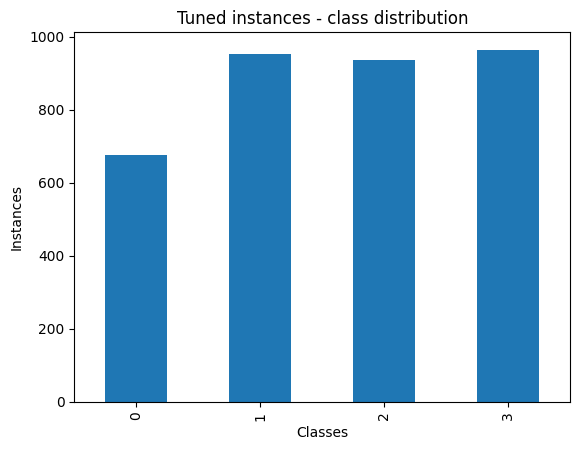

0        4
1        4
2        4
3        4
4        4
        ..
3525    13
3526    13
3527    13
3528    13
3529    13
Name: PID, Length: 3205, dtype: int64
36      9
37      9
38      9
39      9
40      9
       ..
3412    9
3413    9
3414    9
3415    9
3416    9
Name: PID, Length: 325, dtype: int64
torch.Size([3205, 5774])
X shape torch.Size([3205, 1440, 2])
y shape torch.Size([3205])
feature torch.Size([3205, 14])
torch.Size([325, 5774])
X shape torch.Size([325, 1440, 2])
y shape torch.Size([325])
feature torch.Size([325, 14])

################################### My Proposed Features Model ###################################
(3205, 5774) (3205,)
******CNN*******
5: 0.29846153846153844/ 0.2939047340988756
10: 0.31076923076923074/ 0.30803119985650784
15: 0.3261538461538461/ 0.32474772879702457
20: 0.3046153846153846/ 0.302319510202414
25: 0.2953846153846154/ 0.2922265228377148
30: 0.28/ 0.2767774695625384
35: 0.27692307692307694/ 0.27474846536631436
40: 0.27692307692307694/ 0.2749

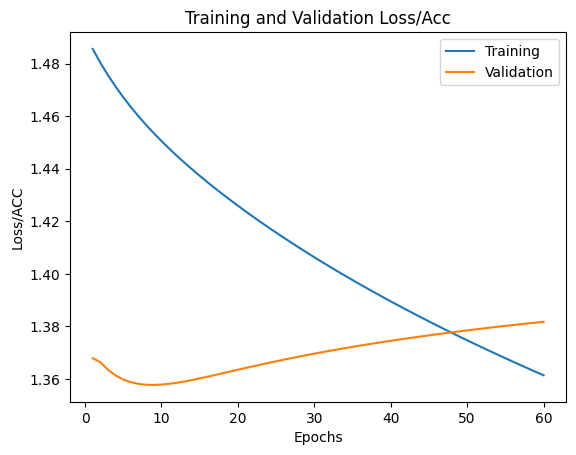

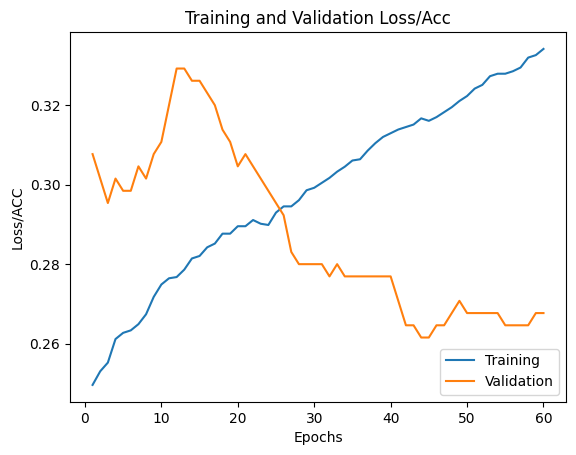

CPU times: user 3min 43s, sys: 2.68 s, total: 3min 45s
Wall time: 3min 47s


In [ ]:
%%time
# Implement.
# Get arguments.
args = parse_args()
# Run the pipeline.
run(args=args)
# Output the results.
output(args=args)

best acc/f1<br>
14: 0.35 / 0.31<br>
11: 0.36942675159235666/ 0.36827769345024824<br>
9: 0.3372093023255814/ 0.3448552492458822<br>
1: 0.42441860465116277/ 0.3756904380289192<br>
26: 0.4011627906976744/ 0.3706307769656186<br>
3: 0.436046511627907/ 0.39856070773887853<br>
8: 0.4069767441860465/ 0.39773562023562026<br>




